# Speech to Speech

## Load Model for speech translation

In [1]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load Data for validation

In [2]:
from datasets import load_dataset

dataset = load_dataset("facebook/voxpopuli", "de", split="validation", streaming=True, trust_remote_code=True)
sample = next(iter(dataset))

In [3]:
sample

{'audio_id': '20130520-0900-PLENARY-17-de_20130520-20:46:00_4',
 'language': 1,
 'audio': {'path': 'dev_part_0/20130520-0900-PLENARY-17-de_20130520-20:46:00_4.wav',
  'array': array([0.00769043, 0.00692749, 0.00082397, ..., 0.00305176, 0.00863647,
         0.00823975]),
  'sampling_rate': 16000},
 'raw_text': 'Und seit zwei Monaten ist ein neuer Präsident im Amt.',
 'normalized_text': 'und seit zwei monaten ist ein neuer präsident im amt.',
 'gender': 'male',
 'speaker_id': '96646',
 'is_gold_transcript': True,
 'accent': 'None'}

In [4]:
from IPython.display import Audio

Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

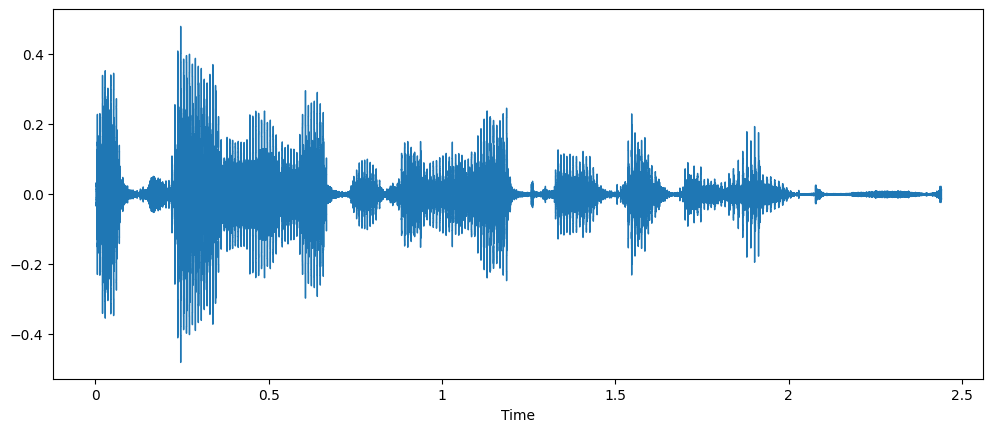

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

plt.figure().set_figwidth(12)
librosa.display.waveshow(sample["audio"]["array"], sr=sample["audio"]["sampling_rate"])

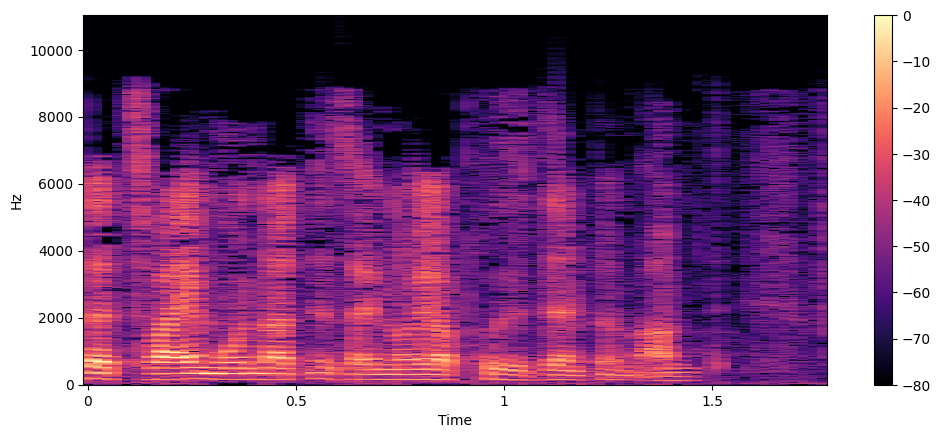

In [6]:
import numpy as np

D = librosa.stft(sample["audio"]["array"])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

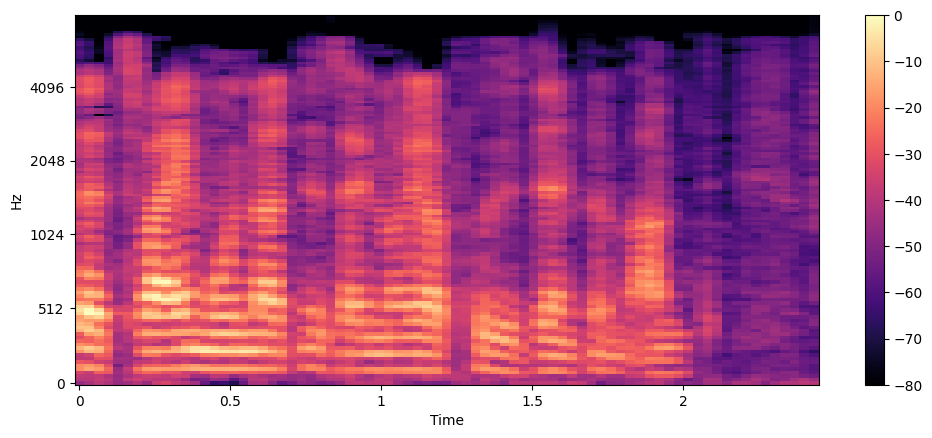

In [7]:
S = librosa.feature.melspectrogram(y=sample["audio"]["array"], sr=sample["audio"]["sampling_rate"], n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sample["audio"]["sampling_rate"], fmax=8000)
plt.colorbar()

In [8]:
def translate(audio):
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "translate", "language": "de"})
    return outputs["text"]

In [9]:
translate(sample["audio"].copy())

' The second month is a new president in the field.'

In [10]:
sample["raw_text"]

'Und seit zwei Monaten ist ein neuer Präsident im Amt.'

## Text to speech

In [11]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [12]:
model.to(device)
vocoder.to(device)

SpeechT5HifiGan(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsampler): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(8,), stride=(4,), padding=(2,))
    (1): ConvTranspose1d(256, 128, kernel_size=(8,), stride=(4,), padding=(2,))
    (2): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(4,), padding=(2,))
    (3): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (1): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256,

Speaker Embeddings

In [13]:
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [14]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    
    return speech.cpu()

In [15]:
speech = synthesise("Hey there! This is a test!")

Audio(speech, rate=16000)

## Combine

In [16]:
import numpy as np

target_dtype = np.int16
max_range = np.iinfo(target_dtype).max


def speech_to_speech_translation(audio):
    translated_text = translate(audio)
    synthesised_speech = synthesise(translated_text)
    synthesised_speech = (synthesised_speech.numpy() * max_range).astype(np.int16)
    
    return 16000, synthesised_speech

In [17]:
sampling_rate, synthesised_speech = speech_to_speech_translation(sample["audio"])

Audio(synthesised_speech, rate=sampling_rate)

In [ ]:
import gradio as gr

demo = gr.Blocks()

mic_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(sources="microphone", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

file_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(sources="upload", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

with demo:
    gr.TabbedInterface([mic_translate, file_translate], ["Microphone", "Audio File"])

demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
